<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Single_Objective_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Objective. Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Base Operations

In [105]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [106]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import random as rm
import os
import subprocess
import torch
import sys
import torch.optim as optim
import glob
import time

from pathlib import Path
from PIL import Image, ImageSequence
from time import sleep
from datetime import datetime, date
from math import sqrt,sin,cos, floor
from scipy.optimize import fsolve
from random import shuffle, randint, sample
from copy import deepcopy

### Global Values

In [107]:
base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Single-Objective"
counter = 0

date_string = date.today()
base_name = f'GD_Brach__{date_string}'
gif_dir = os.path.join(base_path, "gifs/" + base_name)
misc_runs_dir = os.path.join(base_path, "misc_runs/" + base_name)

Path(gif_dir).mkdir(parents=True, exist_ok=True)
Path(misc_runs_dir).mkdir(parents=True, exist_ok=True)

### Hyperparameters

In [226]:
objectives = ["Short Time"]
n_dimensions = 1
n_iterations = 200
n_population = 40
n_generations = 200
n_points = 30

# Probabilities
ps = 0.2 # selection
pc = 1 # crossover
pm = 0.1 # mutation

ps_max = 0.5 # selection
pc_max = 1 # crossover
pm_max = 0.5 # mutation

elitismo = 0.1 

p_variable = True # Varied the probability


# Boundaries 
xl = 0 # left boundary
xr = 1 # rigth boundary
yu = 1 # up boundary
yl = -1 # low boundary
limits = [xl, yl]
weights = [0.1, 0.1]
height = 1
width = 1

seed = 1

show_info = True # See Description Prints
save_gif = True # Save gif image
frames_gif = 100
parents = []

### Common Functions

In [109]:
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal

def makeImage(fp_in, fp_out):
  global counter
  counter += 1
  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  
  img = Image.open(fp_out)
  
def showGif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

def plotFitnessFunction(ax, best_FF):
    ax.clear()
    ax.set_xlabel('# generations')
    ax.set_ylabel('fitness function')
    ax.plot(best_FF, label='best', color='dodgerblue')
    ax.legend()
    ax.text(0.6*len(best_FF), 0.8*max(best_FF), 'best: {:.3f}'.format(best_FF[-1]))


def fitnessFunction(y_no_end_pts, height):
    g = 9.8
    n_segments = len(y_no_end_pts) + 1
    width = 1.0
    delta_x = width/n_segments
    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)

    y = torch.cat((torch.tensor([height]), y_no_end_pts, torch.tensor([0.0])), dim=0)

    d = torch.stack([-(y[i+1] - y[i]) for i in range(n_segments)])

    temp = torch.stack([torch.tensor(0.0)] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = sqrt(2*g)*torch.sqrt(temp)

    v = v[:-1]
    t = (torch.sqrt(v**2 + 2*g*d) - v)/(g*d/torch.sqrt(d**2 + delta_x**2))

    return(sum(t))

## Genetic Algorithm Components



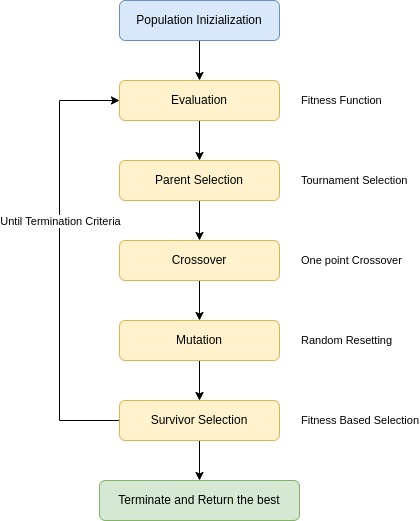

### Initialization


#### Individual

Creating Random Individual

In [110]:
class Individual():

  def __init__(self, n_points=n_points, height=height, **kwargs):
    self.n_segments = n_points
    self.n_pts = n_points+1
    self.width = 1.0
    self.height = height
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    self.sameness_thresh = kwargs.get('sameness_thresh', 1*10.0**(-5))

    self.same_thresh_decay_steps = kwargs.get('same_thresh_decay_steps', None)

    if self.same_thresh_decay_steps is None:
        self.same_thresh_decay_factor = 1.0
    else:
        self.same_thresh_decay_factor = (10.0**-4)**(1.0/self.same_thresh_decay_steps)

    self.mutate_strength_height_frac = kwargs.get('mutate_strength_height_frac', 1/20.0)
    self.mutate_strength = self.height*self.mutate_strength_height_frac
    self.mutate_all_chance = kwargs.get('mutate_all_chance', 0.0)

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + rm.random()*(self.height - (-self.height/frac)))

    self.x.append(1.0)
    self.y.append(0)

    self.sol = None

    #This is just assuming it dropping vertically and then going horizonally at that speed
    g = 9.8
    t1 = sqrt(2*self.height/g)
    v1 = g*t1
    t2 = self.width/v1
    self.max_FF = 40*(t1 + t2)

#### Population

Creating a Population with n-random Individuals

In [111]:
class Population():
  
  def __init__(self, individual_class=Individual, n_population=n_population, **kwargs):
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    print(self.kwargs_str)

    self.individual_class = individual_class
    self.class_name = individual_class.__name__
    self.n_population = n_population
    self.population = [[self.createNewIndivid(**kwargs), 0] for i in range(self.n_population)]
    self.sorted_population = None

    if (show_info):
      self.printPopulation()
      self.plotPopulation()

  def createNewIndivid(self, **kwargs):
    return(self.individual_class(**kwargs))

  def printPopulation(self):
    print("Population Edited Parameters: ")
    print(self.kwargs_str)
    print("--------------------------------")

  def plotPopulation(self,  **kwargs):
    print("Population Diagram: ")
    print("--------------------------------")
    # plot lines
    for individual in self.population:
      plt.plot(individual[0].x, individual[0].y)
    plt.show()


  

### Evaluation

In [112]:
class Fitness():

  global show_info

  def __init__(self, population=Population, **kwargs):
    self.population = population

  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height

    #The coords we've been using (dropped at (0,h), ending at (w,0)), simply add h to y in the end.

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_pts)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    sol_numeric_y = []

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal = self.getFitness(individual)
    individual.y = temp_state

    if show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")

  def getFitness(self, individual):
    g = 9.8

    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
    d = -np.array([individual.y[i+1] - individual.y[i] for i in range(individual.n_segments)])

    #Be careful with signs and indices!
    v = sqrt(2*g)*np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])

    if np.isnan(v).any():
      print('\n\nbad v:',v)
      print('\nbad d sum:',[sum(d[:(i+1)]) for i in range(len(d))])
      print('\nstate', individual.y)
      plt.savefig('test_bad_np.png')
      exit(0)


    #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = v[:-1]
    t = (np.sqrt(v**2 + 2*g*d) - v)/(g*d/np.sqrt(d**2 + individual.delta_x**2))

    F1 = (sum(t))
    return F1

  def getFitnessPopulation(self, sort=False):
    for individual in self.population.population:
      individual[1] = self.getFitness(individual[0])

    if sort:
      self.sortIndividuals()

    if show_info:
      self.printFitnessFunctions()

  def sortIndividuals(self):
    list.sort(self.population.population, key=lambda fitness: fitness[1])

  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.population):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    # Pass this an axis from another program. It will handle showing it and stuff.
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.8*width, 0.9*height, 'ideal: {:.3f}'.format(self.t_ideal))

    if plot_label:
      ax.text(0.8*width, 0.8*height, 'cur. best: {:.3f}'.format(self.getFitness(individual)))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  def plotFitnessFunction(self, ax, best, mean):
    ax.clear()
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')

    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [252]:
class Selection():
  
  def __init__(self, population=Population, ps=ps, **kwargs):
    self.population = population
    self.parents = []
    self.ps = ps
    self.quantity_parents = 3

  # Probabilistic Selection

  def getProbabilisticSelection(self):
    probability = np.random.uniform(
        low=0, high=1, size=self.population.n_population)
    
    probability = probability < self.ps
    if sum(probability == True) > 0:
      self.quantity_parents = sum(probability == True)

  def getParentsSelection(self):
    self.getProbabilisticSelection()
    for i in range(self.quantity_parents):
      self.parents.append(self.tournamentSelection())

    # self.parents = np.unique(self.parents, axis=0)

    if show_info:
      self.printParents()

  def tournamentSelection(self):
    parents = rm.choices(self.population.population, k=5)
    list.sort(parents, key=lambda fitness: fitness[1])

    return (parents[0])

  def printParents(self):
    print('\n-------------------------------------')
    print('Selection Parents')
    print('\n')
    for index, individual in enumerate(self.parents):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def getBestAndMean(self):
    if self.sorted_population is None:
      return((0,0))

    best = self.sorted_population[0][1]
    mean = sum([individfitness[1] for individfitness in self.sorted_population])/(1.0*len(self.population))
    return((best,mean))

  def isSameState(self, other_state):
    max_diff = ((self.n_pts-2)*self.height)**2
    diff = (np.array(self.y) - np.array(other_state.y))[1:-1]
    abs_diff_normed = abs(sum(diff))/(self.n_pts-2)
    
    if abs_diff_normed < self.sameness_thresh:
      return(True)
    else:
      return(False)

  def deleteDuplicates(self,pop):
    unique_individuals = []
    no_duplicates = []
    
    for index,individual in enumerate(pop):
      is_not_unique = np.any([individual.isSameState(other) for other in no_duplicates])
      if not is_not_unique:
        unique_individuals.append(individual.y)
        no_duplicates.append(individual)

    return(no_duplicates)






### Crossover

In [250]:
class Crossover():
  
  def __init__(self, population=Population, parents=parents, ps=pc, **kwargs):
    self.population = population
    self.parents = parents
    self.pc = pc

  def getNewIndividuals():
    rm.shuffle(self.parents)
    for i in len(self.parents):
      self.onePointCrossover(self.parent[i], self.parent[:-i])

  def onePointCrossover(self, parent1, parent2):
    new_child1 = deepcopy(parent1)
    new_child2 = deepcopy(parent2)

    r1 = randint(1,self.population.n_points-3)
    r2 = randint(r1+1,self.population.n_points-2)

    temp = new_child1.y[r1:r2]
    new_child1.y[r1:r2] = new_child2.y[r1:r2]
    new_child2.y[r1:r2] = temp

    return(new_child1, new_child2)


  def mateAvg(self,other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)

    newindivid_1.y = ((np.array(newindivid_1.y) + np.array(newindivid_2.y))/2).tolist()

    return(newindivid_1,newindivid_1)

### Mutation

In [115]:
class Mutation():
  
  def mutate(self):
    self.sameness_thresh *= self.same_thresh_decay_factor

    if random() < self.mutate_all_chance:
      # Mutate all indices by some amount.
      mut_amount = np.random.normal(scale=self.mutate_strength)
      N_mutate = randint(1, self.n_segments-1)
      mutate_indices = sample(list(range(1, self.n_segments)), N_mutate)

      for index in range(1, self.n_segments-1):
        new_height = self.y[index] + mut_amount
        
        if new_height < self.height:
          self.y[index] = new_height

    else:
      # Mutate random set of indices
      N_mutate = randint(1, self.n_segments-1)
      mutate_indices = sample(list(range(1, self.n_segments)), N_mutate)

      for index in mutate_indices:
        new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
        if new_height < self.height:
          self.y[index] = new_height

  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height

### Survivor Selection

In [116]:
class Survivor_Selection():

  def solFound(self):
    max_diff = ((self.n_pts-2)*self.height)**2
    diff = np.array(self.y) - np.array(self.sol_numeric_y)
    abs_diff = sum(diff**2)
    thresh = 1*10.0**(-5)
    if abs_diff/max_diff < thresh:
        print('abs_diff/max_diff: {:.3f}'.format(abs_diff/max_diff))
        return(True)
    else:
        return(False)

## Genetic Algorithm execution

In [255]:
class GeneticAlgorithm():

  # Variable = Variation of the Probability between epochs
  def __init__(self, population=Population, generations=n_generations, variable=p_variable):
    self.n_generations = n_generations 
    self.p_variable = p_variable

    start = time.time()

    if self.p_variable:
      ps = ps_max
      pc = ps_max
      pm = pm_max

    fitness = Fitness(population)
    fitness.getFitnessPopulation()

    selection = Selection(population, ps)
    selection.getParentsSelection()

    end = time.time()

    if show_info:
      print("\n-------------------------------------------")
      print("Process Complete ")
      print("\n")
      print("Time Process: {:20}".format(str(end - start)))
      print("\n-------------------------------------------\n")

    
    

    '''
    def plot_evolution(self,  **kwargs):
      N_gen = kwargs.get('N_gen', 550)
      plot_state = kwargs.get('plot_state', True)
      plot_whole_pop = kwargs.get('plot_whole_pop', False)
      save_best_FF = kwargs.get('save_best_FF', True)

      base_name_temp = f'evolve_{self.class_name}__pop={self.n_population}__gen={N_gen}__{self.kwargs_str}__{date_string}'

      if save_gif:
          N_gif_frames = 100
          gif_dir = os.path.join(base_path, "gifs/" + base_name_temp)
          Path(gif_dir).mkdir(parents=True, exist_ok=True)

      if plot_state:
          fig, axes = plt.subplots(2,1,figsize=(6,8))
          ax_FF = axes[0]
          ax_state = axes[1]
      else:
          fig, ax_FF = plt.subplots(1,1,figsize=(8,8))

      if show_info:
          plt.show(block=False)

      sol_found = False

      best = []
      mean = []
      cur_best, cur_mean = 0, 0

      method_list = [func for func in dir(self.individ_class) if callable(getattr(self.individ_class, func))]

      if plot_state and plot_whole_pop:
          NUM_COLORS = self.n_population + 2
          cm = plt.get_cmap('RdBu')
          cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
          scalar_map = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
          pop_plot_color_list = [scalar_map.to_rgba(i) for i in range(NUM_COLORS)][::-1]


      for i in range(self.generations):
          self.sortIndivids()
          cur_best, cur_mean = self.getBestAndMean()

          best.append(cur_best)
          mean.append(cur_mean)

          if i%max(1, int(N_gen/20.0))==0:
              print('Generation {}, current best = {:.3f}, current pop. size = {}'.format(i, cur_best, len(self.population)))

          if 'solFound' in method_list:
              if self.population[0].solFound():
                  print(f'found solution in generation {i}!\n')
                  if 'printState' in method_list:
                      self.population[0].printState()
                  break

          # Plot the current best and mean.
          self.plotFitnessFunction(ax_FF, best, mean)

          # If we're plotting the state of the population, call their plotState() functions.
          # You can plot either the best member, or the whole pop.
          if plot_state:
              ax_state.clear()

              if plot_whole_pop:
                  for j, ind in enumerate(self.population[::-1]):
                      ind.plotState(ax_state, color=pop_plot_color_list[j])

              self.population[0].plotState(ax_state, color='black', plot_sol=True, plot_label=True)

          if show_info:
              fig.canvas.draw()

          if save_gif:
              if i==0 or (i%max(1, int(N_gen/N_gif_frames))==0):
                  plt.savefig(f'{gif_dir}/{i+1}.png')

          self.mateGrid()



      plt.savefig(f'{misc_runs_dir}/{base_name_temp}.png')

      if save_best_FF:
          np.savetxt(f'{misc_runs_dir}/bestFF_{base_name_temp}.txt', best)

      if save_gif:
          # filepaths
          fp_in = misc_runs_dir + "/*.png"
          fp_out = misc_runs_dir + f"/image{counter+1}.gif"
          makeImage(fp_in, fp_out)

      print('\nending mean = {:.3f}'.format(cur_mean))

      return(self.population[0])
    
    #ending_state = pop.plot_evolution(N_gen=self.generations, plot_whole_pop=True, save_gif=True)
'''




# Test Section

## Individual Random Generation

In [118]:
'''
individual = Individual(n_points=n_points, height=height)
plt.plot(individual.x, individual.y)
plt.title('Individual. Random Generation')
plt.show()

y = torch.tensor(individual.y[1:-1], requires_grad=True)

fitness = Fitness(individual)
fitness.getBestCurve(individual)

adam_optimizer = optim.RMSprop([y])

best = []
mean = []

for t in range(n_generations):

    J = fitnessFunction(y, height)

    best.append(J.item())
    mean.append(np.mean(best))

    individual.y[1:-1] = y.detach().tolist()

    if save_gif:
        if t==0 or (t%max(1, int(n_generations/frames_gif))==0):
            plt.savefig(f'{gif_dir}/{t+1}.png')

    if show_info:
      if t%int(n_generations/20)==0:
        print('iteration {:10}     |    loss: {:.4f}'.format(t, J.item()))

    adam_optimizer.zero_grad()
    J.backward()
    adam_optimizer.step()


plt.savefig(f'{misc_runs_dir}.png')


if show_info:
  print('\n-------------------------------------')

  fig, axes = plt.subplots(2,1,figsize=(6,8))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  ax_FF = axes[0]
  ax_state = axes[1]
  fitness.plotFitnessFunction(ax_FF, best, mean)
  fitness.plotState(individual, ax_state, width, height, color='tomato', plot_sol=True, plot_label=True)

  fig.canvas.draw()


if save_gif:
    fp_in = gif_dir + "/*.png"
    fp_out = gif_dir + f'/image{counter+1}.gif'
    makeImage(fp_in, fp_out)

'''


'\nindividual = Individual(n_points=n_points, height=height)\nplt.plot(individual.x, individual.y)\nplt.title(\'Individual. Random Generation\')\nplt.show()\n\ny = torch.tensor(individual.y[1:-1], requires_grad=True)\n\nfitness = Fitness(individual)\nfitness.getBestCurve(individual)\n\nadam_optimizer = optim.RMSprop([y])\n\nbest = []\nmean = []\n\nfor t in range(n_generations):\n\n    J = fitnessFunction(y, height)\n\n    best.append(J.item())\n    mean.append(np.mean(best))\n\n    individual.y[1:-1] = y.detach().tolist()\n\n    if save_gif:\n        if t==0 or (t%max(1, int(n_generations/frames_gif))==0):\n            plt.savefig(f\'{gif_dir}/{t+1}.png\')\n\n    if show_info:\n      if t%int(n_generations/20)==0:\n        print(\'iteration {:10}     |    loss: {:.4f}\'.format(t, J.item()))\n\n    adam_optimizer.zero_grad()\n    J.backward()\n    adam_optimizer.step()\n\n\nplt.savefig(f\'{misc_runs_dir}.png\')\n\n\nif show_info:\n  print(\'\n-------------------------------------\')\n\n

## Population Random Generation

n_points=30__height=1__sameness_thresh=0.15__mutate_strength_height_frac=0.21__same_thresh_decay_steps=200
Population Edited Parameters: 
n_points=30__height=1__sameness_thresh=0.15__mutate_strength_height_frac=0.21__same_thresh_decay_steps=200
--------------------------------
Population Diagram: 
--------------------------------


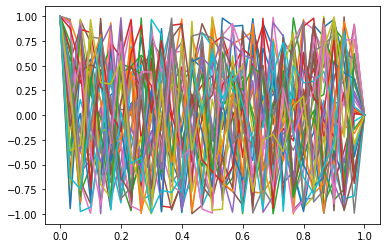


-------------------------------------
Objective Fitness 1:  Short Time


Individual          0     |    Fitness: 6.2208
Individual          1     |    Fitness: 6.7496
Individual          2     |    Fitness: 6.8448
Individual          3     |    Fitness: 3.8968
Individual          4     |    Fitness: 3.8341
Individual          5     |    Fitness: 7.3392
Individual          6     |    Fitness: 4.9873
Individual          7     |    Fitness: 4.7050
Individual          8     |    Fitness: 7.2566
Individual          9     |    Fitness: 5.3140
Individual         10     |    Fitness: 5.7468
Individual         11     |    Fitness: 5.1859
Individual         12     |    Fitness: 4.2134
Individual         13     |    Fitness: 5.2913
Individual         14     |    Fitness: 4.9297
Individual         15     |    Fitness: 6.3133
Individual         16     |    Fitness: 6.4944
Individual         17     |    Fitness: 4.2784
Individual         18     |    Fitness: 5.5993
Individual         19     |    Fi

In [256]:
population = Population(Individual, n_population, n_points=n_points, height=height, sameness_thresh=15*10**-2, mutate_strength_height_frac=0.21, same_thresh_decay_steps=n_generations)

GeneticAlgorithm(population=population, 
                 generations=n_generations,
                 variable=p_variable)


# Extra

In [281]:
test = [
        [2,3],
        [1,7]]

rm.shuffle(test)

print(len(test))
print(test)

rm.shuffle(test)
for index, i in enumerate(test):
  print("Index: ", index)
  print(i[])

2
[[1, 7], [2, 3]]
Index:  0
7
Index:  1
3


In [259]:
len(parents)

2

In [ ]:
unique = reduce(lambda l, x: l.append(x) or l if x not in l else l, mylist, [])

In [238]:
test = [
        [1,1],[1,2],
        [5,1],[1,2],
        [1,1]]


print(test)
test = np.unique(test, axis=0)


print(test)


[[1, 1], [1, 2], [5, 1], [1, 2], [1, 1]]
[[1 1]
 [1 2]
 [5 1]]


In [213]:
quantity_parents = 2
probability = np.random.uniform(
    low=0, high=1, size=population.n_population)

probability = probability < ps
quantity_parents = (sum(probability == True) if sum(probability == True) == 0 else quantity_parents) 


In [214]:
quantity_parents

2

n_points=30__height=1__sameness_thresh=0.15__mutate_strength_height_frac=0.21__same_thresh_decay_steps=200
Population Edited Parameters: 
n_points=30__height=1__sameness_thresh=0.15__mutate_strength_height_frac=0.21__same_thresh_decay_steps=200
--------------------------------
Population Diagram: 
--------------------------------


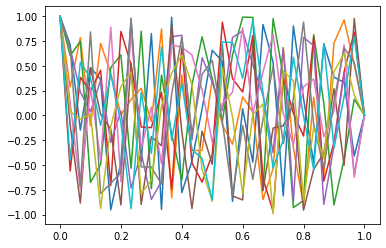

In [205]:
population = Population(Individual, n_population, n_points=n_points, height=height, sameness_thresh=15*10**-2, mutate_strength_height_frac=0.21, same_thresh_decay_steps=n_generations)


In [173]:
fitness = Fitness(population)
fitness.getFitnessPopulation()

selection = Selection(population, ps)
selection.getProbabilisticSelection()


-------------------------------------
Objective Fitness 1:  Short Time


Individual          0     |    Fitness: 4.6466
Individual          1     |    Fitness: 6.1622
Individual          2     |    Fitness: 5.6396
Individual          3     |    Fitness: 5.2775
Individual          4     |    Fitness: 5.7113
Individual          5     |    Fitness: 4.4460
Individual          6     |    Fitness: 6.8010
Individual          7     |    Fitness: 5.1501
Individual          8     |    Fitness: 5.6342
Individual          9     |    Fitness: 6.2555

-------------------------------------
Selection Parents


[[[<__main__.Individual object at 0x7f00969716d0>, 4.44602901619775], [<__main__.Individual object at 0x7f00969e12d0>, 5.27753768278875], [<__main__.Individual object at 0x7f00969716d0>, 4.44602901619775], [<__main__.Individual object at 0x7f00969e12d0>, 5.27753768278875], [<__main__.Individual object at 0x7f00969716d0>, 4.44602901619775], [<__main__.Individual object at 0x7f00969716d0>, 4.4460

In [215]:
parents = []
def getParentsSelection():
  for i in range(2):
    parents.append(tournamentSelection())

def tournamentSelection():
  parents1 = rm.choices(population.population, k=5)
  list.sort(parents1, key=lambda fitness: fitness[1])
  print(parents1[1])
  return (parents1[0])

In [216]:
getParentsSelection()

[<__main__.Individual object at 0x7f00968c4fd0>, 0]
[<__main__.Individual object at 0x7f00968b1790>, 0]


In [219]:
print(parents[1][1])

0


In [177]:
selection.parents

[[[<__main__.Individual at 0x7f00969716d0>, 4.44602901619775],
  [<__main__.Individual at 0x7f00969e12d0>, 5.27753768278875],
  [<__main__.Individual at 0x7f00969716d0>, 4.44602901619775],
  [<__main__.Individual at 0x7f00969e12d0>, 5.27753768278875],
  [<__main__.Individual at 0x7f00969716d0>, 4.44602901619775],
  [<__main__.Individual at 0x7f00969716d0>, 4.44602901619775]]]

In [160]:
selection.parents[0]


[[<__main__.Individual at 0x7f0096acffd0>, 4.769876057395866],
 [<__main__.Individual at 0x7f0096acffd0>, 4.769876057395866],
 [<__main__.Individual at 0x7f0096acffd0>, 4.769876057395866],
 [<__main__.Individual at 0x7f0096acf7d0>, 4.511896406028464],
 [<__main__.Individual at 0x7f0096acf890>, 4.930054628150543],
 [<__main__.Individual at 0x7f0096acfe50>, 3.901687291208805]]

In [ ]:
fitness = Fitness(population)
fitness.getFitnessPopulation()

selection = Selection(population)
selection.getParentsSelection()

In [ ]:
population.n_population 

In [ ]:
for i in range(int(population.n_population * ps)):
  print("Hello")

In [ ]:
parents = []
parents.append([selection.tournamentSelection() for i in range(population.n_population * ps)])


In [ ]:
import random 
parents = []
parents = random.choices(population.population, k=5)


In [ ]:
parents

In [ ]:
posiciones_mutadas = np.random.uniform(
                      low=0,
                      high=1,
                      size=5
                    )


print(posiciones_mutadas[1])

In [ ]:
posiciones = np.random.uniform(
                      low=0,
                      high=300,
                      size=5
                    )

In [ ]:
posiciones_mutadas = posiciones_mutadas < 0.8

In [ ]:
print(posiciones_mutadas)

In [ ]:
print(posiciones)

In [ ]:
print(posiciones[posiciones_mutadas])

In [ ]:
posiciones[posiciones_mutadas] = np.logical_not(posiciones[posiciones_mutadas])

In [ ]:
posiciones[posiciones_mutadas] = np.logical_not(posiciones[posiciones_mutadas])

In [ ]:
if sum(posiciones == True) == 0:
      indice = np.random.choice(
                  a       = np.arange(5),
                  size    = 1, 
                  replace = False
                )
      posiciones[indice] = True

In [ ]:
posiciones

In [ ]:
sum(posiciones)

In [ ]:
sum(posiciones_mutadas == True)

In [ ]:
n_variables = 5

In [ ]:
predictores = np.arange(n_variables)

In [ ]:
predictores

In [ ]:
if sum(posiciones == True) != 0:
  print(sum(posiciones == True))

In [ ]:
posiciones_mutadas

In [ ]:
a = np.array([4, 6, 8])
b = np.array([False, True, True])
print(a[b])

In [ ]:
start = time.time()
n_generations = 10
end = time.time()

print("Duración optimización: {:10.10}".format(str(end - start)))
print("Duración optimización: {:10.10}".format(str(end - start)))
print('Generation {}, current best = {:.3f}, current pop. size = {:.3f}'.format(n_generations, start, end))
print('current pop. size = {:.3}'.format(str(end - start)))

print("Generation: {}".format(n_generations))


In [124]:
probability = np.random.uniform(
    low=0, high=1, size=population.n_population)

probability = probability < 0.6

In [125]:
print(probability)
print(ps)
print(sum(probability == True))


[ True  True  True  True  True False  True  True  True False]
0.2
8
